In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'Lake_data_svd&grp.xlsx'  # Adjust path as needed
data = pd.read_excel(file_path)

# Check the first few rows
print(data.head())

KeyboardInterrupt: 

Inspect the columns and data types:

In [11]:
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Sitio            1009 non-null   object        
 1   Depth Group      1009 non-null   object        
 2   Date             1009 non-null   datetime64[ns]
 3   Depth (m)        1009 non-null   float64       
 4   Temp. (°C)       1009 non-null   float64       
 5   Chl a (µg/l)     1009 non-null   float64       
 6   Ph (Unidad)      1009 non-null   float64       
 7   Turbidity (NTU)  1009 non-null   float64       
 8   DO (mg/L)        1009 non-null   float64       
 9   TDS (mg/l)       1009 non-null   float64       
 10  DBO (mg/l)       1009 non-null   float64       
 11  Sechi  (m)       1009 non-null   float64       
 12  NO3 (µg/L)       1009 non-null   float64       
 13  PO4 (µg/L)       1009 non-null   float64       
 14  NH4 (µg/L)       1009 non-null   float64

Convert Dates: Ensure your Date column is in datetime format and set it as the index
Select target variable, to forecast:

In [19]:
print(data.columns)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Select the target variable (e.g., Temperature)
series = data['Temp. (°C)']

Index(['Sitio', 'Depth Group', 'Date', 'Depth (m)', 'Temp. (°C)',
       'Chl a (µg/l)', 'Ph (Unidad)', 'Turbidity (NTU)', 'DO (mg/L)',
       'TDS (mg/l)', 'DBO (mg/l)', 'Sechi  (m)', 'NO3 (µg/L)', 'PO4 (µg/L)',
       'NH4 (µg/L)', 'PT (µg/l)', 'NT (µg/l)'],
      dtype='object')


Check for Stationarity: Use a Dickey-Fuller Test to determine if differencing is needed:

In [22]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print()

# Extract and print critical values
print("Critical Values:")
for key, value in result[4].items():
    print(f"{key}: {value}")

ADF Statistic: -2.9210834633730607
p-value: 0.042950636910575477
Critical Values:
1%: -3.4369259442540416
5%: -2.8644432969122833
10%: -2.5683158550174094


Interpretation of Results
ADF Statistic:

The ADF statistic is -2.92. For stationarity, we compare this to the critical values:
At the 5% significance level, the critical value is likely close to -2.86 (depending on the dataset size).
Since -2.92 is less than -2.86, we reject the null hypothesis of non-stationarity.
p-value:

The p-value is 0.0429 (< 0.05), which also indicates stationarity at the 5% significance level.
However, it is close to the threshold, suggesting that the series might not be strongly stationary.

At the 5% significance level, the time series is stationary. This means:
No differencing is required (d=0) in the SARIMA model for stationarity purposes.
However, given that the ADF statistic is close to the critical value, you should:
* Double-check for seasonality or other trends using time-series decomposition.
* Consider testing with seasonal differencing (D=1) if seasonality is present.

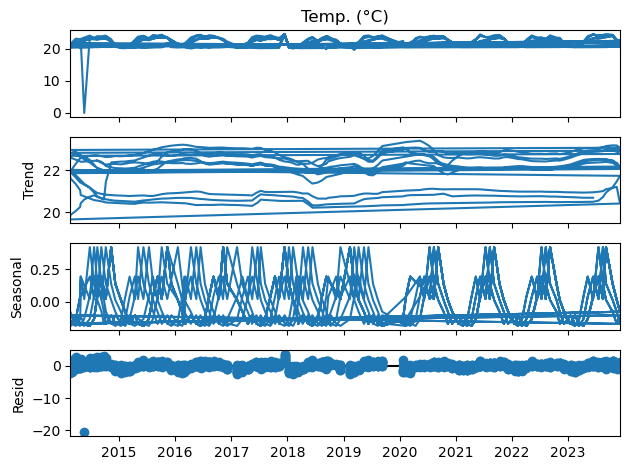

In [23]:
#Visualize the Data:

#Confirm seasonality and trends by plotting the series or using seasonal decomposition.

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series, model='additive', period=12)  # Adjust period based on data
decomposition.plot()
plt.show()


The above decomposition plot breaks the time series into trend, seasonal, and residual components:

Observed (Top Panel):

* This is the original time series, showing the overall data.

Trend (Second Panel):

* The trend component shows long-term movement in the data.
* There seems to be a weak but slightly varying trend, mostly around a consistent range (20°C–22°C).
* The trend is not very prominent, which aligns with the series being close to stationary.

Seasonal (Third Panel):

* This shows the repeating patterns in the data, capturing seasonality.
* A clear annual seasonal pattern is present, with fluctuations repeating every year.
* Peaks and troughs are regular, confirming a need for seasonal components (P, D, Q, m) in the SARIMA model.

Residual (Bottom Panel):

* The residuals represent noise or random variations after removing trend and seasonality.
* Residuals are fairly small but include some outliers (e.g., a large negative spike around 2015).


Step 1: Plot ACF and PACF to Estimate Parameters
To identify the non-seasonal (p, q) and seasonal (P, Q) orders, we’ll plot the ACF and PACF.

<Figure size 1200x600 with 0 Axes>

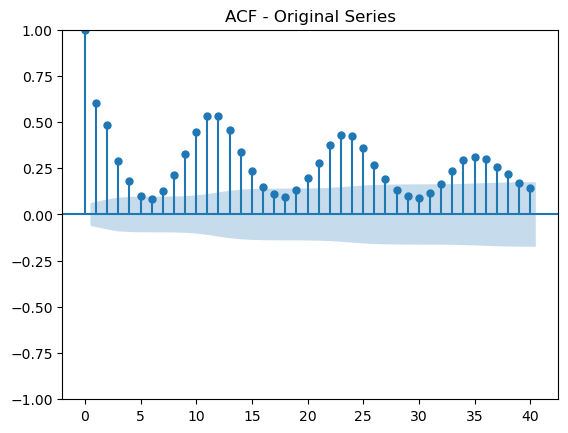

<Figure size 1200x600 with 0 Axes>

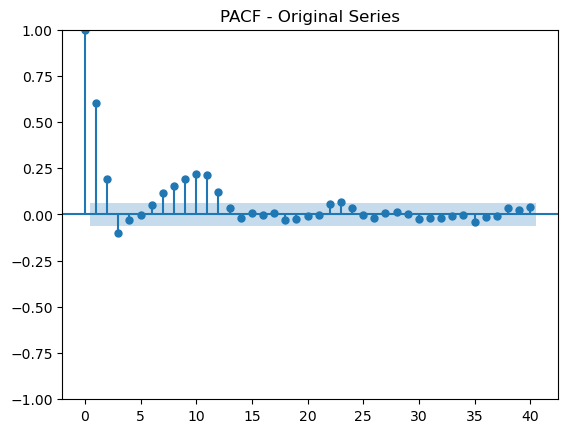

In [24]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the series
plt.figure(figsize=(12, 6))
plot_acf(series, lags=40, title="ACF - Original Series")
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(series, lags=40, title="PACF - Original Series")
plt.show()



**Interpretation of ACF and PACF Plots**
These plots help determine the autoregressive (AR) and moving average (MA) orders for both the non-seasonal and seasonal components of your SARIMA model.

**ACF Plot (Autocorrelation Function)**
* Observations:

The ACF shows a significant spike at lag 1, followed by a tapering pattern.
It also exhibits clear seasonal peaks at multiples of 12 (lags 12, 24, etc.), which confirms monthly seasonality.
The tapering pattern suggests that the moving average (MA) component is necessary.

* Implications:

For non-seasonal components:
MA (q) ≈ 1 (as the first lag is significant).
For seasonal components:
Seasonal MA (Q) ≈ 1 (based on the seasonal peaks).

**PACF Plot (Partial Autocorrelation Function)**
* Observations:

The PACF shows a significant spike at lag 1 but drops sharply after that.
There’s no tapering pattern, and it becomes flat after lag 1.

* Implications:

For non-seasonal components:
AR (p) ≈ 1 (as the first lag is significant).
For seasonal components:
Seasonal AR (P) ≈ 0 or 1 (depending on the significance of the seasonal lags).

Based on the observations these are the proposed SARIMA variables that we can fit to the model:

* Non-Seasonal Parameters (p, d, q):
p=1 (from PACF spike at lag 1).
d=0 (from stationarity confirmed by ADF test).
q=1 (from ACF tapering at lag 1).

* Seasonal Parameters (P, D, Q, m):
P=1 (based on seasonal spikes in ACF).
D=1 (to capture seasonal differencing).
Q=1 (based on seasonal spikes in ACF).
m=12 (monthly seasonality).

c:\Users\nicks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nicks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nicks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\nicks\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                         Temp. (°C)   No. Observations:                 1009
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood               -1551.323
Date:                            Fri, 17 Jan 2025   AIC                           3112.646
Time:                                    18:48:41   BIC                           3137.170
Sample:                                         0   HQIC                          3121.969
                                           - 1009                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7125      0.033     21.579      0.000       0.648       0.777
ma.L1         -0.3090      0.033   

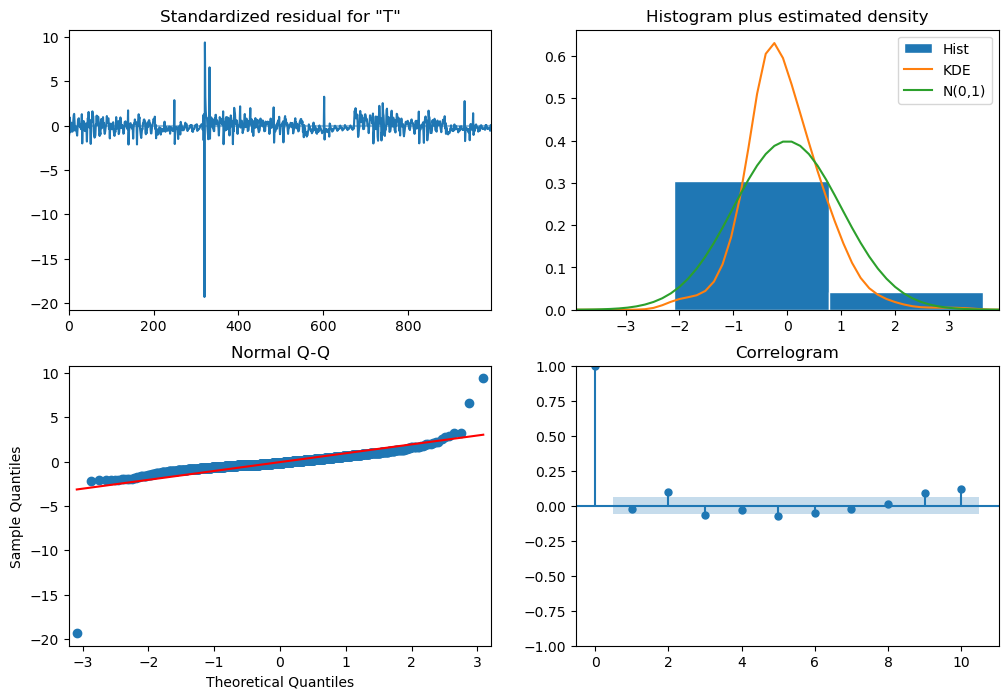

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model with determined parameters
model = SARIMAX(series,
                order=(1, 0, 1),            # Non-seasonal (p, d, q)
                seasonal_order=(1, 1, 1, 12))  # Seasonal (P, D, Q, m)
results = model.fit()

# Print summary
print(results.summary())

# Plot diagnostics to evaluate residuals
results.plot_diagnostics(figsize=(12, 8))
plt.show()
